In [1]:
using LinearAlgebra
using PyPlot
using ForwardDiff

using DelimitedFiles

In [2]:
h = 0.05

0.05

In [3]:
function diffEquation(x,u)
    # enter mathematica result in here
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]    
    x4 = x[4]
    U =u
     

    dif3 = (0.385862*x3 + 0.954338*x4*cos(x1) + 1148.44*(-0.00338094*U*cos(x1) - 0.0317834*sin(x1)) + 0.013122*(x3^2)*cos(x1)*sin(x1) )/(-0.344849 + 0.006561*cos(2*x1))
    
    dif4 = ( 0.667644*x4 +0.1008*x3*cos(x1)  + 0.00918*(x3^2)*sin(x1) + 141.782*(-0.0191587*U - 0.00336267*sin(2*x1)) )/(-0.344849 + 0.006561*cos(2*x1))
    return [x3,x4,dif3,dif4]
end

diffEquation (generic function with 1 method)

In [4]:
function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = diffEquation( x, u)
    f2 = diffEquation( x + 0.5*h*f1, u)
    f3 = diffEquation( x + 0.5*h*f2, u)
    f4 = diffEquation( x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [5]:
Nx = 4     # dim of state
Nu = 1     # dim of controls
Tfinal = 2.0 
Nt = Int(Tfinal/h)+1    # num of time steps
thist = Array(range(0,h*(Nt-1), step=h));

# Cost weights
Q = Diagonal([1.0*ones(2); 0.1*ones(2)]);
R = 0.8;
Qn = Array(10000.0*I(Nx));

In [6]:
function stage_cost(x,u)
    return 0.5*((x-xgoal)'*Q*(x-xgoal)) + 0.5*R*u*u
end

stage_cost (generic function with 1 method)

In [7]:
function terminal_cost(x)
    return 0.5*(x-xgoal)'*Qn*(x-xgoal)
end

terminal_cost (generic function with 1 method)

In [8]:
function cost(xtraj,utraj)
    J = 0.0
    for k = 1:(Nt-1)
        J += stage_cost(xtraj[:,k],utraj[k])
    end
    J += terminal_cost(xtraj[:,Nt])
    return J
end

cost (generic function with 1 method)

In [9]:
#Initial guess
x0 = [-3.14; 0; 0; 0]
xgoal = [0; 0; 0; 0]
xtraj = kron(ones(1,Nt), x0)
utraj = randn(Nt-1);

In [10]:
#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[k])
end
J = cost(xtraj,utraj)

57441.456048753505

In [11]:
#DDP Algorithm
p = zeros(Nx,Nt)
P = zeros(Nx,Nx,Nt)
d = ones(Nt-1)
K = zeros(Nu,Nx,Nt-1)
ΔJ = 0.0

gx = zeros(Nx)
gu = 0.0
Gxx = zeros(Nx,Nx)
Guu = 0.0
Gxu = zeros(Nx)
Gux = zeros(Nx)

iter = 0
while maximum(abs.(d[:])) > 1e-4
    iter += 1
    
    p = zeros(Nx,Nt)
    P = zeros(Nx,Nx,Nt)
    d = ones(Nt-1)
    K = zeros(Nu,Nx,Nt-1)
    ΔJ = 0.0

    p[:,Nt] = Qn*(xtraj[:,Nt]-xgoal)
    P[:,:,Nt] = Qn
    
    #Backward Pass
    for k = (Nt-1):-1:1
        #Calculate derivatives
        q = Q*(xtraj[:,k]-xgoal)
        r = R*utraj[k]
    
        A = ForwardDiff.jacobian(dx->dynamics_rk4(dx,utraj[k]),xtraj[:,k])
        B = ForwardDiff.derivative(du->dynamics_rk4(xtraj[:,k],du),utraj[k])
    
        gx = q + A'*p[:,k+1]
        gu = r + B'*p[:,k+1]
    
        Gxx = Q + A'*P[:,:,k+1]*A
        Guu = R + B'*P[:,:,k+1]*B
        Gxu = A'*P[:,:,k+1]*B
        Gux = B'*P[:,:,k+1]*A
        
        d[k] = Guu\gu
        K[:,:,k] .= Guu\Gux
    
        p[:,k] .= dropdims(gx - K[:,:,k]'*gu + K[:,:,k]'*Guu*d[k] - Gxu*d[k], dims=2)
        P[:,:,k] .= Gxx + K[:,:,k]'*Guu*K[:,:,k] - Gxu*K[:,:,k] - K[:,:,k]'*Gux
    
        ΔJ += gu'*d[k]
    end
    #display(j)

    #Forward rollout with line search
    xn = zeros(Nx,Nt)
    un = zeros(Nt-1)
    xn[:,1] = xtraj[:,1]
    α = 1.0

    for k = 1:(Nt-1)
        un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
        xn[:,k+1] .= dynamics_rk4(xn[:,k],un[k])
    end
    Jn = cost(xn,un)
    
    while Jn > (J - 1e-2*α*ΔJ)
        α = 0.5*α
        for k = 1:(Nt-1)
            un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
            xn[:,k+1] .= dynamics_rk4(xn[:,k],un[k])
        end
        Jn = cost(xn,un)
    end
    #display(α)
    
    J = Jn
    xtraj .= xn
    utraj .= un
end

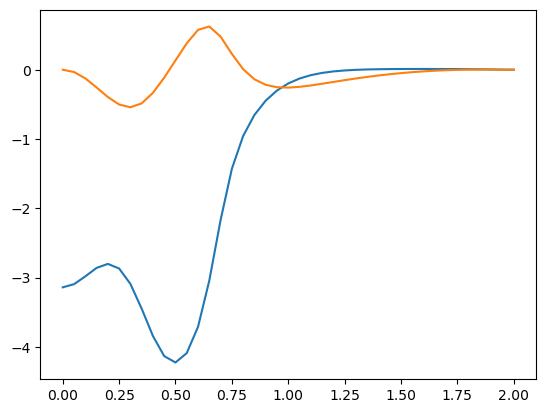

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006140C130>

In [12]:
plot(thist,xtraj[1,:])
plot(thist,xtraj[2,:])

In [13]:
iter

1652

In [14]:
J


321.9922792494425

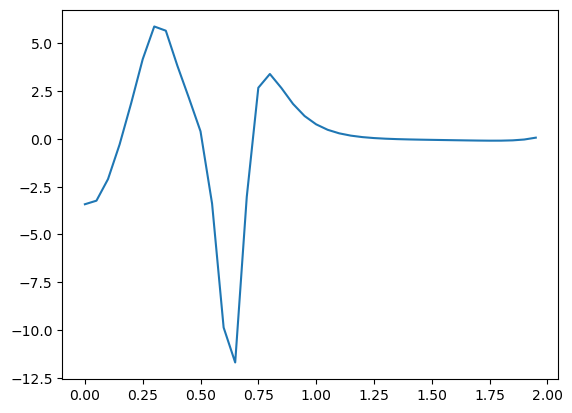

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000627AE4F0>

In [15]:
plot(thist[1:Nt-1],utraj)

In [16]:
writedlm( "trajectoryFriction.csv",  [xtraj[1,:] xtraj[2,:] xtraj[3,:] xtraj[4,:]], ',')

In [17]:
writedlm( "uTrajectoryFriction.csv",  utraj, ',')